# Chapter 13: Loading and Preprocessing Data with TensorFlow

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tfx==0.21.2
    print("You can safely ignore the package incompatibility errors.")
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Data API Overview
- TensorFlow's *Data API* makes it easy to ingest large datasets and preprocess them efficiently
- the whole Data API revolves around the concept of a *dataset*: a sequence of data items
- let's create a dataset entirely in RAM using `tf.data.Dataset.from_tensor_slices()`:

In [3]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

- the `from_tensor_slices()` function takes a tensor and creates a `tf.data.Dataset` whose elements are all the slices of `X`
- so this dataset contains 10 items: tensor 0, 1, 2, ..., 9
- we could have also written: 

In [4]:
dataset = tf.data.Dataset.range(10)
dataset

<RangeDataset shapes: (), types: tf.int64>

- you can simply iterate over a dataset's items:

In [5]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


## Chaining Transformations
- once you have a dataset, you can apply all sorts of transformations to it by calling its transformation methods
- each method returns a new dataset, so you can chain transformations like this:

In [6]:
dataset = dataset.repeat(3).batch(7) # set drop_remainder=True to drop final batch so all batches are same size
for item in dataset:
    print(item) 

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


- we first call the `repeat()` method on the original dataset, which returns a new dataset that will repeat the items of the original dataset 3 times
- then we call the `batch()` method on this new dataset, which again, creates a new dataset that group the items of the previous dataset in batches of 7 items
- the dataset methods do *not* modify datasets, they create new ones, so make sure to keep a reference to these new datasets (`dataset = ...`) or nothing will happen
---
- you can transform the items by calling the `map()` method
- for example, this creates a new dataset with all items doubled:

In [7]:
dataset = dataset.map(lambda x: x * 2) # (new dataset)
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int64)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int64)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int64)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int64)
tf.Tensor([16 18], shape=(2,), dtype=int64)


- the `map()` method can apply any preprocessing you desire to your data
---
- while the `map()` method applies a transformation to each item, the `apply()` method applies a transformation to the whole dataset
- for example, the following code applies the `unbatch()` function to the dataset:

In [8]:
#dataset = dataset.apply(tf.data.experimental.unbatch()) # now deprecated

- it is also possible to filter the dataset using the `filter()` method:

In [9]:
dataset = dataset.filter(lambda x: x < 10)  # keep only items < 10
for item in dataset.take(3): # to only look at just a few items from a dataset (the take() method)
    print(item)

ValueError: `predicate` return type must be convertible to a scalar boolean tensor. Was TensorSpec(shape=(None,), dtype=tf.bool, name=None).

## Shuffling the Data (w/ CSV Files)
### Small Datasets
- Gradient Descent works best when the instances in the training set are independent and identically distributed
- a good way to ensure this is to use the `shuffle()` method, which creates a new dataset that starts by filling up a buffer with the first items from the source dataset
- then, whenever it is asked for an item, it will pull one out randomly from the buffer and replace it with a fresh one from the source dataset until it has iterated through it
- you must specify the buffer size, and it's crucial you make the buffer large enough
- **for example, the following code creates and displays a dataset containing integers 0 to 9, repeated 3 times, shuffled using a buffer size of 3 and random seed of 42, and batched with a batch size of 7**:

In [10]:
tf.random.set_seed(42) # if you want the same random order every time you run your program

dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=3, seed=42).batch(7, drop_remainder=True)
for item in dataset:
    print(item)

tf.Tensor([1 3 0 4 2 5 6], shape=(7,), dtype=int64)
tf.Tensor([8 7 1 0 3 2 5], shape=(7,), dtype=int64)
tf.Tensor([4 6 9 8 9 7 0], shape=(7,), dtype=int64)
tf.Tensor([3 1 4 5 2 8 7], shape=(7,), dtype=int64)


### Large Datasets
- for a large dataset that does not fit in memory, this simple shuffling-buffer approach is not sufficient, as the buffer will be so small compared to the actual size of the dataset
- **one solution is to shuffle the source data itself**
- a common technique is to split the source data into multiple files, then read them in a random order during training
- on top of that, you can indeed at a shuffling buffer using the `shuffle()` method
---
- let's start by loading and preparing the California housing dataset
- we first load it, then split it into a training set, a validation set, and a test set, and finally we scale it:

In [11]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [12]:
# load it, split it into a training set, a validation set, and a test set
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [13]:
# scaling the training set
scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

- for a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel
- to demonstrate this, let's start by splitting the housing dataset and save it to 20 CSV files:

In [14]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [15]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]

header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

- okay, now let's take a peek at the first few lines of one of these CSV files:

In [16]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


- or in text mode:

In [17]:
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


- let's suppose that `train_filepaths` contains the list of training file paths (and you have a `valid_filepaths` and `test_filepaths`)

In [18]:
train_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

- alternatively, you could use file patterns
- `list_files()` returns a dataset that shuffles the file paths, which is generally a good thing:

In [19]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [20]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_04.csv', sh

- next, you can call the `interleave()` method to read from 5 files at a time and interleave their lines (skipping the first line of each file, which is the header row, using the `skip()` method):

In [21]:
n_readers = 5 # to read 5 files at a time
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1), # skipping the header row
    cycle_length=n_readers)

In [22]:
for line in dataset.take(5):
    print(line.numpy())

b'4.6477,38.0,5.03728813559322,0.911864406779661,745.0,2.5254237288135593,32.64,-117.07,1.504'
b'8.72,44.0,6.163179916317992,1.0460251046025104,668.0,2.794979079497908,34.2,-118.18,4.159'
b'3.8456,35.0,5.461346633416459,0.9576059850374065,1154.0,2.8778054862842892,37.96,-122.05,1.598'
b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526'
b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625'


- these are the first rows (ignoring the header rows) if 5 CSV files, chosen randomly
- this looks good, but these are just byte strings: we need to parse them and scale the data

## Preprocessing the Data (w/ CSV Files)
- let's implement a small function that will perform this preprocessing:

In [23]:
n_inputs = 8 # X_train.shape[-1]

@tf.function
def preprocess(line): # to parse the byte strings and scale the data
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

- the code assumes that we have precomputed the mean and standard deviation of each feature in the training set
- `X_mean` and `X_std` are just 1D tensors (or NumPy arrays) containing 8 floats (1 per input feature)
- let's test this preprocessing function:

In [24]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

- looks good: now let's apply the function to the dataset and put everything together
---
### Putting Everything together
- **to make the code reusable, let's put together everything we have discussed so far into a small helper function: it will create and return a dataset that will efficiently load California housing data from multiple CSV files, preprocess it, shuffle it, optionally repeat it, and batch it**:

In [25]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5, # reads 5 files at a time
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads) # map() transforms the data
    dataset = dataset.batch(batch_size) # batches of 32
    return dataset.prefetch(1) # prefetch(1) is important for performance

### Prefetching
- by calling `prefetch(1)` at the end, we are creating a dataset that will do its best to always be one batch ahead
- in other words, while our training algorithm is working on one batch, the dataset will already be working in parallel on getting the next batch ready, which can drastically improve performance
- in general, just prefetching one batch is fine, but in some cases you may need to prefetch a few more
- with prefetching, the CPU and the GPU work in parallel: as the GPU works on one batch, the CPU works on the next
---
- **a large amount of RAM is crucial for computer vision**
---
- if the dataset is small enough to fit in memory, you can significantly speed up training by using the dataset's `cache()` method to cache its content to RAM
- you should do this after loading and preprocessing the data, but before shuffling, repeating, batching, and prefetching

## Using the Dataset with tf.keras (w/ CSV Files)
- now we can use the `csv_reader_dataset()` function to create a dataset for the training set
- note that we do not need to repeat it, as this will be taken care of by `tf.keras`
- more specifically, the `fit()` method will take care of repeating the training set
- we also create datasets for the validation set and the test set:

In [26]:
train_set = csv_reader_dataset(train_filepaths, repeat=None) 
valid_set = csv_reader_dataset(valid_filepaths) 
test_set = csv_reader_dataset(test_filepaths)

- now we can simply build and train a Keras model using these datasets
- all we need to do it pass the training and validation datasets to the `fit()` method, instead of `X_train`, `y_train`, `X_valid`, and `y_valid`:

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [28]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [29]:
batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=valid_set)

Train for 362 steps
Epoch 1/10
362/362 [==============================] - 1s 3ms/step - loss: 1.4500 - val_loss: 21.6255
Epoch 2/10
362/362 [==============================] - 0s 1ms/step - loss: 0.9054 - val_loss: 0.7099
Epoch 3/10
362/362 [==============================] - 0s 1ms/step - loss: 0.6092 - val_loss: 0.6093
Epoch 4/10
362/362 [==============================] - 0s 1ms/step - loss: 0.6023 - val_loss: 0.5710
Epoch 5/10
362/362 [==============================] - 0s 1ms/step - loss: 0.5790 - val_loss: 0.6348
Epoch 6/10
362/362 [==============================] - 0s 1ms/step - loss: 0.5521 - val_loss: 0.6665
Epoch 7/10
362/362 [==============================] - 0s 1ms/step - loss: 0.5219 - val_loss: 0.5159
Epoch 8/10
362/362 [==============================] - 0s 1ms/step - loss: 0.5318 - val_loss: 0.4932
Epoch 9/10
362/362 [==============================] - 0s 1ms/step - loss: 0.4981 - val_loss: 0.4707
Epoch 10/10
362/362 [==============================] - 0s 1ms/step - loss: 0.47

- we can pass a dataset top the `evaluate()` and `predict()` methods:

In [30]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 1ms/step - loss: 0.4788


0.47875127770145487

In [31]:
new_set = test_set.map(lambda X, y: X) # we could instead just pass test_set, Keras would ignore the labels
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

array([[1.772925 ],
       [1.4905939],
       [2.510351 ],
       ...,
       [1.8501377],
       [1.2474439],
       [2.8345075]], dtype=float32)

- unlike the other sets, the `new_set` will usually not contain labels (if it does, Keras will ignore them)
---
- congratulations, you now know how to build powerful input pipelines using the Data API
- however, so far we have used CSV files, which are common, simple, and convenient, but not really efficient, and do not support large or complex data structures (such as images or audio) very well

## The TFRecord Format
- the TFRecord format is TensorFlow's preferred format for storing large amounts of data and reading it efficiently
- it is a very simple binary format that just contains a sequence of binary records of varying sizes
- you can easily *create* a TFRecord file using the `tf.io.TFRecordWriter` class:

In [32]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

- and you can then use a `tf.data.TFRecordDataset` to read one or more TFRecord files:

In [33]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


- by default, a `TFRecordDataset` will read files one by one, but you can make it read multiple files in parallel and interleave their records by setting `num_parallel_reads`
---
### Compressed TFRecord files
- it can sometimes be useful to compress your TFRecord files, especially if they need to be loaded via a network connection
- you can create a compressed TFRecord file by setting the `options` argument:

In [34]:
# compressing TFRecord files
options = tf.io.TFRecordOptions(compression_type="GZIP") 
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

- and when reading a compressed TFRecord file, you need to specify the compression type:

In [35]:
# specifying compression type when reading compressed TFRecord file
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP") 
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


### A Brief Introduction to Protocol Buffers
- even though each record can use any binary format you want, TFRecord files usually contain serialized protocal buffers (*protobufs*)
- this is a portable, extensible, and efficient binary format
- protobufs are defined using a simple language that looks like this:

In [36]:
%%writefile person.proto
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

Overwriting person.proto


- this definition says we are using version 3 of the protobuf format, and it specifies that each `Person` object may (optionally) have a `name` of type `string`, an `id` of type `int32`, and zero or more `email` fields, each of type `string`
- the numbers `1`, `2`, and `3` are the field identifiers: they will be used in each record's binary representation
- once you have a definition in a *.proto* file, you can compile it
- to illustrate the basics, let's look at a simple example that uses the access classes generated for the `Person` protobuf:

In [37]:
from person_pb2 import Person

person = Person(name="Al", id=123, email=["a@b.com"])  # create a Person
print(person)  # display the Person

name: "Al"
id: 123
email: "a@b.com"



In [38]:
person.name  # read a field

'Al'

In [39]:
person.name = "Alice"  # modify a field

In [40]:
person.email[0]  # repeated fields can be accessed like arrays

'a@b.com'

In [41]:
person.email.append("c@d.com")  # add an email address

In [42]:
s = person.SerializeToString()  # serialize to a byte string
s

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [43]:
person2 = Person()  # create a new Person
person2.ParseFromString(s)  # parse the byte string (27 bytes)

27

In [44]:
person == person2  # now they are equal

True

- we could save the serialized `Person` object to a TFRecord file, then we could load and parse it
- however, `SerializeToString()` and `ParseFromString()` are not TensorFlow operations (and neither are the other operations in the above code), so they cannot be included in a TensorFlow function
- fortunately, TensorFlow does include special protobuf definitions for which it provides parsing operations
---
### TensorFlow Protobufs
- the main protobuf used in a TFRecord file is the `Example` protobuf, which represents one instance in a dataset
- it contains a list of named features, where each feature can either be a list of byte strings, a list of floats, or a list of integers
- here is the protobuf definition:
```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```
- here is how you could create a `tf.train.Example` representing the same person as earlier and write it to a TFRecord file:

In [45]:
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }))

- this code is a bit verbose and repetitive, but it's rather straightforward
- now that we have an `Example` protobuf, we can serialize it by calling its `SerializeToString()` method, then write the resulting data to a TFRecord file:

In [46]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

- now that we have a nice TFRecord file containing a serialized `Example`, let's try to load it:
---
### Loading and Parsing Examples
- to load the serialized `Example` protobufs, we will use a `tf.data.TFRecordDataset` once again, and we will parse each `Example` using `tf.io.parse_single_example()`
- the following code defines a description dictionary, then it iterates over the `TFRecordDataset` and parses the serialized `Example` protobuf this dataset contains:

In [47]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)

In [48]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x2ce5f85bcf8>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

- you can convert a sparse tensor to a dense tensor using `tf.sparse.to_dense()`, but in this case, it is simpler just to access its values:

In [49]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [50]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

### Handling Lists of Lists Using the SequenceExample Protobuf
- here is the definition of the `SequenceExample` protobuf:
```proto
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
  Features context = 1;
  FeatureLists feature_lists = 2;
};
```

In [51]:
FeatureList = tf.train.FeatureList
FeatureLists = tf.train.FeatureLists
SequenceExample = tf.train.SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [52]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [53]:
serialized_sequence_example = sequence_example.SerializeToString()

In [54]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)

In [55]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x2ce522c8470>,
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25], dtype=int64)>}

In [56]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [57]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x2ce5d2eff28>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x2ce5d2efcc0>}

In [58]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


## The Features API
### Preprocessing the Input Features
- preparing your data for a neural network requires converting all features into numerical features, generally normalizing them, and more
- in particular, if your data contains categorical features or text features, they need to be converted to numbers
- **as an example, let's use the variant of the California housing dataset that we used in Chapter 2, since it contains categorical features and missing values**:

In [59]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [60]:
fetch_housing_data()

In [61]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [62]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### housing_median_age
- `tf.feature_column.numeric_column()` represents real valued or numerical features:

In [108]:
print(housing.housing_median_age.min(), housing.housing_median_age.max())

1.0 52.0


In [73]:
housing_median_age = tf.feature_column.numeric_column("housing_median_age")
housing_median_age

NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [112]:
from sklearn.preprocessing import StandardScaler

X_mean = scaler.mean_
X_std = scaler.scale_

age_mean, age_std = X_mean[1], X_std[1]
housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age", normalizer_fn=lambda x: (x - age_mean) / age_std) # the most common use case of this function is normalization
housing_median_age

NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <lambda> at 0x000002CE62FACD08>)

- `tf.feature_column.bucketized_column()` returns a bucketized column
- buckets include the left boundary, and exclude the right boundary: namely, `boundaries=[0., 1., 2.]` generates buckets `(-inf, 0.)`, `[0., 1.)`, `[1., 2.)`, and `[2., +inf)`

In [86]:
bucketized_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=[-1., -0.5, 0., 0.5, 1.]) # age was just scaled
bucketized_age

BucketizedColumn(source_column=NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <lambda> at 0x000002CE348E1048>), boundaries=(-1.0, -0.5, 0.0, 0.5, 1.0))

### median_income
- again using `tf.feature_column.bucketized_column()`

In [107]:
print(housing.median_income.min(), housing.median_income.max()) # hence our boundaries

0.4999 15.0001


In [81]:
median_income = tf.feature_column.numeric_column("median_income")
bucketized_income = tf.feature_column.bucketized_column(
    median_income, boundaries=[1.5, 3., 4.5, 6.])
bucketized_income

BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))

### ocean_proximity
- we start by making a vocabulary list of all the categorical features in the `ocean_proximity` column
- `tf.feature_column.categorical_column_with_vocabulary_list()` is to be used when your inputs are in string or integer format, and you have an in-memory vocabulary mapping each value to an integer ID

In [83]:
ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list(
    "ocean_proximity", ocean_prox_vocab) # column name, vocabulary list
ocean_proximity

VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

### example using tf.feature_column.categorical_column_with_hash_bucket
- `tf.feature_column.categorical_column_with_hash_bucket()` is to be used when your sparse features are in string or integer format, and you want to distribute your inputs into a finite number of buckets by hashing

In [84]:
# just an example, it's not used later on
city_hash = tf.feature_column.categorical_column_with_hash_bucket(
    "city", hash_bucket_size=1000)
city_hash

HashedCategoricalColumn(key='city', hash_bucket_size=1000, dtype=tf.string)

### creating age_and_ocean_proximity (a crossed column)
- `tf.feature_column.crossed_column()` returns a column for performing crosses of categorical features

In [89]:
age_and_ocean_proximity = tf.feature_column.crossed_column(
    [bucketized_age, ocean_proximity], hash_bucket_size=100) # number of buckets
age_and_ocean_proximity

CrossedColumn(keys=(BucketizedColumn(source_column=NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <lambda> at 0x000002CE348E1048>), boundaries=(-1.0, -0.5, 0.0, 0.5, 1.0)), VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), hash_bucket_size=100, hash_key=None)

### latitude
- the code below provides insight to the creation of our boundaries:

In [105]:
print(housing.latitude.min(), housing.latitude.max()) # hence boundaries

32.54 41.95


In [91]:
latitude = tf.feature_column.numeric_column("latitude")
latitude

NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [94]:
print(list(np.linspace(32., 42., 20 - 1)))

[32.0, 32.55555555555556, 33.111111111111114, 33.666666666666664, 34.22222222222222, 34.77777777777778, 35.333333333333336, 35.888888888888886, 36.44444444444444, 37.0, 37.55555555555556, 38.111111111111114, 38.666666666666664, 39.22222222222222, 39.77777777777778, 40.333333333333336, 40.888888888888886, 41.44444444444444, 42.0]


In [92]:
bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=list(np.linspace(32., 42., 20 - 1)))
bucketized_latitude

BucketizedColumn(source_column=NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(32.0, 32.55555555555556, 33.111111111111114, 33.666666666666664, 34.22222222222222, 34.77777777777778, 35.333333333333336, 35.888888888888886, 36.44444444444444, 37.0, 37.55555555555556, 38.111111111111114, 38.666666666666664, 39.22222222222222, 39.77777777777778, 40.333333333333336, 40.888888888888886, 41.44444444444444, 42.0))

### longitude

In [106]:
print(housing.longitude.min(), housing.longitude.max()) # hence our boundaries

-124.35 -114.31


In [95]:
longitude = tf.feature_column.numeric_column("longitude")

In [96]:
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=list(np.linspace(-125., -114., 20 - 1)))

### creating location
- again using `tf.feature_column.crossed_column()`

In [113]:
location = tf.feature_column.crossed_column(
    [bucketized_latitude, bucketized_longitude], hash_bucket_size=1000)

### creating ocean_proximity_one_hot
- `tf.feature_column.indicator_column()` represents the multi-hot representation of a given categorical column
- for a DNN model, an `indicator_column` can be used to wrap any `categorical_column` (e.g., to feed to DNN)

In [116]:
ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)
ocean_proximity_one_hot

IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0))

### creating ocean_proximity_embed
- `tf.feature_column.embedding_column()` is to be used when your inputs are sparse, but you want to convert them to a dense representation (e.g., to feed to a DNN)
- input must be a `categorical_column`
- we use an `embedding_column` if the number of buckets/unique(values) are large

In [117]:
ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity,
                                                           dimension=2)
ocean_proximity_embed

EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=2, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x000002CE643DB128>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)

## TF Transform
- if preprocessing is computationally expensive, then handling it before training rather than on the fly may give you a significant speed up: the data will be preprocessed just once per instance *before* training, rather than once per instance and per epoch *during* training
- if the dataset is small enough to fit in RAM, you can use its `cache()` method
- if the dataset is too large, then tools like Apache Beam or Spark will help as they let you run efficient data processing pipelines over large amounts of data
---
- this works great and indeed can speed up training, but there is one problem: once your model is trained, suppose you want to deploy it to a mobile app
- in that case, you will need to write some code in your app to preprocess the data before it is fed to the model
- this can become a maintenance nightmare, as whenever you want to change the preprocessing logic, you will need to update your Apache code and your mobile app code, which is very time consuming and can introduce a lot of bugs
---
- one improvement would be to take the trained model (trained on data that was preprocessed by your Apache Beam or Spark code) and, before deploying it to your app, add extra preprocessing layers to take care of preprocessing on the fly
---
- **however, if this all sounds like a hassle and you just want to define your preprocessing operations just once, then TF Transform is right for you**
- TF Transform is part of TensorFlow Extended (TFX), an end-to-end platform for productionizing TensorFlow models
- first, to use a TFX component such as TF Transform, you must install it; it does not come bundled with TensorFlow
- second, you define your preprocessing function just once (in Python) by using TF Transform functions for scaling, bucketizing, and more (you can also use any TensorFlow operations you need)
- here is what this preprocessing function might look like if we just had 2 features:

In [119]:
try:
    import tensorflow_transform as tft

    def preprocess(inputs):  # inputs is a batch of input features
        median_age = inputs["housing_median_age"]
        ocean_proximity = inputs["ocean_proximity"]
        standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
        ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
        return {
            "standardized_median_age": standardized_age,
            "ocean_proximity_id": ocean_proximity_id
        }
except ImportError:
    print("TF Transform is not installed. Try running: pip3 install -U tensorflow-transform") # sweet, it worked

- next, TF Transform lets you apply this `preprocess()` function to the whole training set using Apache Beam (it provides an `AnalyzeAndTransformDataset` class that you can use for this purpose in your Apache Beam pipeline) 
- in this process, it will also compute all the necessary statistics over the whole training set: in the example above, the mean and standard deviation of the `housing_median_age` feature, and the vocabulary for the `ocean_proximity` feature
- the components that compute these statistics are called *analyzers*
---
- importantly, TF Transform will also generate an equivalent TensorFlow Function that you can plug into the model you deploy
- this TF Function includes some constants that correspond to all the necessary statistics computed by Apache Beam (the mean, standard deviation, and vocabulary)

## The TensorFlow Datasets (TFDS) Project
- the TFDS project makes it very easy to download common datasets
- the list includes image datasets, text datasets, audio datasets, and video datasets
- visit http://homl.info/tfds to view the full list along with descriptions
- for example, let's download MNIST:

In [121]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.

Dl Completed...: 100%|██████████| 4/4 [00:02<00:00,  1.36 file/s]

Dataset mnist downloaded and prepared to C:\Users\stuar\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


- you can apply any transformation you want (typically shuffling, batching, and prefetching), and you're ready to train your model
- the `load()` function shuffles each data shard it downloads (only for the training set), which may not be sufficient, so it's best to shuffle the training data some more:

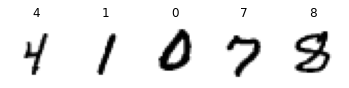

In [122]:
plt.figure(figsize=(6,3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break # just showing part of the first batch

- note that each item in the dataset is a dictionary containing both the features and the labels
- Keras, however, expects each item to be a tuple containing 2 elements (the features and labels)
- to handle this, you can transform the dataset using the `map()` method: 

In [123]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"])) # transforming the data
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[4 1 0 7 8 1 2 7 1 6 6 4 7 7 3 3 7 9 9 1 0 6 6 9 9 4 8 9 4 7 3 3]


- however, it is simpler to ask the `load()` function to do this for you by setting `as_supervised=True`
- this way, you can then pass the dataset directly to your `tf.keras` model:

In [127]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [128]:
datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True) # transforming data
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat().prefetch(1) # shuffling data
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

Train for 1875 steps
Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 31.9638 - accuracy: 0.8409
Epoch 2/5
1875/1875 [==============================] - 2s 859us/step - loss: 25.4987 - accuracy: 0.8701
Epoch 3/5
1875/1875 [==============================] - 2s 925us/step - loss: 25.0071 - accuracy: 0.8723
Epoch 4/5
1875/1875 [==============================] - 2s 888us/step - loss: 24.3472 - accuracy: 0.8758
Epoch 5/5
1875/1875 [==============================] - 2s 905us/step - loss: 23.7253 - accuracy: 0.8783


- this was quite a technical chapter, and you may feel that it is a bit far from the abstract beauty of neural networks, but Deep Learning often involves large amounts of data, and knowing how to load, parse, and preprocess it efficiently is a crucial skill to have
- in the next chapter, we will look at convolutional neural networks, which are among the most successful neural network architectures for image processing and many other applications

## Exercises
---
- 1) *Why would you want to use the Data API?*
---
- The Data API makes it easy to efficiently preprocess a large dataset.
---
- 2) *What are the benefits of splitting a large dataset into multiple files?*
---
- Splitting a large dataset into multiple files makes it possible to shuffle it at a coarse level before shuffling it at a finer level using a shuffling buffer. It also makes it possible to handle huge datasets that do not fit on a single machine.
---
- 3) *During training, how can you tell that your input pipeline is the bottleneck? What can you do to fix it?*
---
- You can use TensorBoard to visualize profiling data: if the GPU is not fully utilized then your input pipeline is likely to be the bottleneck. Just make sure your preprocessing code is optimized.
---
- 4) *Can you save any binary data to a TFRecord file, or only serialized protocol buffers?*
---
- You can save any binary data to a TFRecord file, however, in practice, most TFRecord files contain sequences of serialized protocol buffers. 
---
- 5) *Why would you go through the hassle of converting all your data to the `Example` protobuf format? Why not use your own protobuf definition?*
---
- The `Example` protobuf format has the advantage that TensorFlow provides some operations to parse it. However, if it does not cover your use case, you can define your own protocol buffer (which is more complicated).
---
- 6) *When using TFRecords, when would you want to activate compression? Why not do it systematically?*
---
- You generally want to activate compression if the TFRecord files will need to be downloaded by the training script, as compression will make files smaller and thus reduce download time. 
---
- 7) *Data can be preprocessed directly when writing the data files, or within the `tf.data` pipeline, or in preprocessing layers within your model, or using TF Transform. Can you list a few pros and cons of each option?*
---
- If you preprocess the data when creating the data files, the training script will run faster. The trained model will expect preprocessed data, so you will have to add preprocessing code in your application before it calls the model.

- `tf.data` makes it easy to build highly efficient and customizable preprocessing pipelines. On the downside, preprocessing the data will slow down training, and each training instance will be preprocessed once per epoch rather than just once if the data was preprocessed when creating the data files.

- If you add preprocessing layers to your mode, you will only have to write the preprocessing code once for both training and inference. On the downside (like with `tf.data` ), preprocessing the data will slow down training, and each training instance will be preprocessed once per epoch.

- **Lastly, using TF Transform for preprocessing gives you many benefits from the previous options: the preprocessed data is materialized, each instance is preprocessed just once (speeding up training), and preprocessing layers get generated automatically so you only need to write the preprocessing code once. This is, overall, the best option, however, TF Transform is a difficult tool to master.**
---
- 8) *Name a few common techniques you can use to encode categorical features. What about text?*
---
- To encode categorical features with no natural order, use one-hot-encoding or, if there are many categories, use embeddings.

- For text, use bag-of-words representation or encode each word using embeddings.

### 9)
_Exercise a): Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized `Example` protobuf with two features: the serialized image (use `tf.io.serialize_tensor()` to serialize each image), and the label. Note: for large images, you could use `tf.io.encode_jpeg()` instead. This would save a lot of space, but it would lose a bit of image quality._

In [129]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [130]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [131]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)) # shuffling the training set
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [132]:
def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    #image_data = tf.io.encode_jpeg(image[..., np.newaxis])
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }))

- the following function saves a given dataset to a set of TFRecord files:

In [133]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [134]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

_Exercise b): Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data._

In [135]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    #image = tf.io.decode_jpeg(example["image"])
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [136]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(train_filepaths)
test_set = mnist_dataset(train_filepaths)

In [137]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

standardization = Standardization(input_shape=[28, 28])
# or perhaps soon:
#standardization = keras.layers.Normalization()

sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)

model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [140]:
from datetime import datetime
logs = os.path.join(os.curdir, "my_logs",
                    "run_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2330 - accuracy: 0.9138 - val_loss: 0.2090 - val_accuracy: 0.9249
Epoch 2/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2218 - accuracy: 0.9199 - val_loss: 0.1914 - val_accuracy: 0.9279
Epoch 3/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2056 - accuracy: 0.9251 - val_loss: 0.1844 - val_accuracy: 0.9322
Epoch 4/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1947 - accuracy: 0.9287 - val_loss: 0.1680 - val_accuracy: 0.9406
Epoch 5/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1851 - accuracy: 0.9329 - val_loss: 0.1653 - val_accuracy: 0.9404


### 10)
_Exercise a): Download the [Large Movie Review Dataset](https://homl.info/imdb), which contains 50,000 movies reviews from the [Internet Movie Database](https://imdb.com/). The data is organized in two directories, `train` and `test`, each containing a `pos` subdirectory with 12,500 positive reviews and a `neg` subdirectory with 12,500 negative reviews. Each review is stored in a separate text file. There are other files and folders (including preprocessed bag-of-words), but we will ignore them in this exercise._

In [141]:
from pathlib import Path

DOWNLOAD_ROOT = "http://ai.stanford.edu/~amaas/data/sentiment/"
FILENAME = "aclImdb_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)
path = Path(filepath).parent / "aclImdb"
path

84131840/84125825 [==============================] - 14s 0us/step


WindowsPath('C:/Users/stuar/.keras/datasets/aclImdb')

In [142]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

(12500, 12500, 12500, 12500)

_Exercise b): Split the test set into a validation set (15,000) and a test set (10,000)._

In [143]:
np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

_Exercise c): Use tf.data to create an efficient dataset for each set._

In [146]:
def imdb_dataset(filepaths_positive, filepaths_negative, n_read_threads=5):
    dataset_neg = tf.data.TextLineDataset(filepaths_negative,
                                          num_parallel_reads=n_read_threads)
    dataset_neg = dataset_neg.map(lambda review: (review, 0))
    dataset_pos = tf.data.TextLineDataset(filepaths_positive,
                                          num_parallel_reads=n_read_threads)
    dataset_pos = dataset_pos.map(lambda review: (review, 1))
    return tf.data.Dataset.concatenate(dataset_pos, dataset_neg)

In [147]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

32.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [148]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).cache().repeat(10): pass # added cache()

16.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [149]:
batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(25000).batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

_Exercise d): Create a binary classification model, using a `TextVectorization` layer to preprocess each review. If the `TextVectorization` layer is not yet available (or if you like a challenge), try to create your own custom preprocessing layer: you can use the functions in the `tf.strings` package, for example `lower()` to make everything lowercase, `regex_replace()` to replace punctuation with spaces, and `split()` to split words on spaces. You should use a lookup table to output word indices, which must be prepared in the `adapt()` method._

In [150]:
def preprocess(X_batch, n_words=50): # function to preprocess reviews
    shape = tf.shape(X_batch) * tf.constant([1, 0]) + tf.constant([0, n_words])
    Z = tf.strings.substr(X_batch, 0, 300)
    Z = tf.strings.lower(Z)
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    Z = tf.strings.split(Z)
    return Z.to_tensor(shape=shape, default_value=b"<pad>")

X_example = tf.constant(["It's a great, great movie! I loved it.", "It was terrible, run away!!!"])
preprocess(X_example)

<tf.Tensor: shape=(2, 50), dtype=string, numpy=
array([[b'it', b's', b'a', b'great', b'great', b'movie', b'i', b'loved',
        b'it', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
       [b'it', b'was', b'terrible', b'run', b'away', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'

In [151]:
from collections import Counter

def get_vocabulary(data_sample, max_size=1000):
    preprocessed_reviews = preprocess(data_sample).numpy()
    counter = Counter()
    for words in preprocessed_reviews:
        for word in words:
            if word != b"<pad>":
                counter[word] += 1
    return [b"<pad>"] + [word for word, count in counter.most_common(max_size)]

get_vocabulary(X_example)

[b'<pad>',
 b'it',
 b'great',
 b's',
 b'a',
 b'movie',
 b'i',
 b'loved',
 b'was',
 b'terrible',
 b'run',
 b'away']

In [152]:
class TextVectorization(keras.layers.Layer):
    def __init__(self, max_vocabulary_size=1000, n_oov_buckets=100, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.max_vocabulary_size = max_vocabulary_size
        self.n_oov_buckets = n_oov_buckets

    def adapt(self, data_sample):
        self.vocab = get_vocabulary(data_sample, self.max_vocabulary_size)
        words = tf.constant(self.vocab)
        word_ids = tf.range(len(self.vocab), dtype=tf.int64)
        vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
        self.table = tf.lookup.StaticVocabularyTable(vocab_init, self.n_oov_buckets)
        
    def call(self, inputs):
        preprocessed_inputs = preprocess(inputs)
        return self.table.lookup(preprocessed_inputs)

In [153]:
max_vocabulary_size = 1000
n_oov_buckets = 100

sample_review_batches = train_set.map(lambda review, label: review)
sample_reviews = np.concatenate(list(sample_review_batches.as_numpy_iterator()),
                                axis=0)

text_vectorization = TextVectorization(max_vocabulary_size, n_oov_buckets,
                                       input_shape=[])
text_vectorization.adapt(sample_reviews)

In [154]:
text_vectorization.vocab[:10] # first 10 words in the vocabulary

[b'<pad>', b'the', b'a', b'of', b'and', b'i', b'to', b'is', b'this', b'it']

In [155]:
simple_example = tf.constant([[1, 3, 1, 0, 0], [2, 2, 0, 0, 0]])
tf.reduce_sum(tf.one_hot(simple_example, 4), axis=1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[2., 2., 0., 1.],
       [3., 0., 2., 0.]], dtype=float32)>

In [156]:
class BagOfWords(keras.layers.Layer):
    def __init__(self, n_tokens, dtype=tf.int32, **kwargs):
        super().__init__(dtype=tf.int32, **kwargs)
        self.n_tokens = n_tokens
    def call(self, inputs):
        one_hot = tf.one_hot(inputs, self.n_tokens)
        return tf.reduce_sum(one_hot, axis=1)[:, 1:]

In [157]:
n_tokens = max_vocabulary_size + n_oov_buckets + 1 # add 1 for <pad>
bag_of_words = BagOfWords(n_tokens)

In [158]:
model = keras.models.Sequential([ # now we're ready to train our model
    text_vectorization,
    bag_of_words,
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 22s 28ms/step - loss: 0.5435 - accuracy: 0.7146 - val_loss: 0.5181 - val_accuracy: 0.7347
Epoch 2/5
782/782 [==============================] - 10s 12ms/step - loss: 0.4723 - accuracy: 0.7681 - val_loss: 0.5087 - val_accuracy: 0.7419
Epoch 3/5
782/782 [==============================] - 10s 12ms/step - loss: 0.4240 - accuracy: 0.8027 - val_loss: 0.5183 - val_accuracy: 0.7395
Epoch 4/5
782/782 [==============================] - 9s 12ms/step - loss: 0.3571 - accuracy: 0.8472 - val_loss: 0.5386 - val_accuracy: 0.7352
Epoch 5/5
782/782 [==============================] - 8s 11ms/step - loss: 0.2769 - accuracy: 0.8971 - val_loss: 0.5708 - val_accuracy: 0.7279


_Exercise e): Add an `Embedding` layer and compute the mean embedding for each review, multiplied by the square root of the number of words (see Chapter 16). This rescaled mean embedding can then be passed to the rest of your model._

In [159]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)    
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_mean(inputs, axis=1) * sqrt_n_words

another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])
compute_mean_embedding(another_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[2.3570225, 3.2998314, 1.4142135],
       [2.       , 0.       , 0.       ]], dtype=float32)>

In [160]:
tf.reduce_mean(another_example, axis=1) * tf.sqrt([[2.], [1.]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[2.3570225, 3.2998314, 1.4142135],
       [2.       , 0.       , 0.       ]], dtype=float32)>

In [161]:
embedding_size = 20

model = keras.models.Sequential([
    text_vectorization,
    keras.layers.Embedding(input_dim=n_tokens,
                           output_dim=embedding_size,
                           mask_zero=True), # <pad> tokens => zero vectors
    keras.layers.Lambda(compute_mean_embedding),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

_Exercise f): Train the model and see what accuracy you get. Try to optimize your pipelines to make training as fast as possible._

In [162]:
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 8s 10ms/step - loss: 0.5571 - accuracy: 0.7069 - val_loss: 0.5174 - val_accuracy: 0.7361
Epoch 2/5
782/782 [==============================] - 6s 8ms/step - loss: 0.4961 - accuracy: 0.7566 - val_loss: 0.5219 - val_accuracy: 0.7304
Epoch 3/5
782/782 [==============================] - 6s 8ms/step - loss: 0.4862 - accuracy: 0.7608 - val_loss: 0.5124 - val_accuracy: 0.7419
Epoch 4/5
782/782 [==============================] - 6s 8ms/step - loss: 0.4776 - accuracy: 0.7623 - val_loss: 0.5111 - val_accuracy: 0.7391
Epoch 5/5
782/782 [==============================] - 6s 8ms/step - loss: 0.4711 - accuracy: 0.7633 - val_loss: 0.5099 - val_accuracy: 0.7415


_Exercise g): Use TFDS to load the same dataset more easily: `tfds.load("imdb_reviews")`._

In [163]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]

Dl Completed...: 0 url [00:00, ? url/s]Downloading and preparing dataset imdb_reviews/plain_text/1.0.0 (download: 80.23 MiB, generated: Unknown size, total: 80.23 MiB) to C:\Users\stuar\tensorflow_datasets\imdb_reviews\plain_text\1.0.0...

Dl Completed...: 100%|██████████| 1/1 [00:13<00:00, 13.81s/ url]
0 examples [00:00, ? examples/s]

 93%|█████████▎| 46622/50000 [00:00<00:00, 63298.37 examples/s]Dataset imdb_reviews downloaded and prepared to C:\Users\stuar\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [164]:
for example in train_set.take(1):
    print(example["text"])
    print(example["label"])

tf.Tensor(b'This is a big step down after the surprisingly enjoyable original. This sequel isn\'t nearly as fun as part one, and it instead spends too much time on plot development. Tim Thomerson is still the best thing about this series, but his wisecracking is toned down in this entry. The performances are all adequate, but this time the script lets us down. The action is merely routine and the plot is only mildly interesting, so I need lots of silly laughs in order to stay entertained during a "Trancers" movie. Unfortunately, the laughs are few and far between, and so, this film is watchable at best.', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
